In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from nndrain.tensor_edit import TensorEdit
from nndrain.simplify_linear import SimplifyLinear
import nndrain.utils as utils


utils.set_seed(42)

In [2]:
# Fully connected neural network with SimplifyLinear modules
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc = nn.ModuleList()

        for i_l in range(len(hidden_size)+1):
            in_size = 0
            out_size = 0
            if i_l==0:
                in_size = input_size
                out_size = hidden_size[0]
                simplify_row = True
                simplify_col = False
                exclude_from_drain = True
            elif i_l == len(hidden_size):
                in_size = hidden_size[-1]
                out_size = output_size
                simplify_row = False
                simplify_col = True
                exclude_from_drain = False
            else:
                in_size = hidden_size[i_l-1]
                out_size = hidden_size[i_l]
                simplify_row = True
                simplify_col = True
                exclude_from_drain = False

            sl = SimplifyLinear(in_size, out_size, simplify_row, simplify_col, min_row=2, min_col=2, exclude_from_drain=exclude_from_drain)
            self.fc.append(sl)
            
        self.apply(self._init_weights)
        self.activation = nn.ReLU()

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, x):
        out = x
        for i_l, l in enumerate(self.fc):
            out = self.fc[i_l](out)
            if i_l<len(self.fc)-1:
                out = self.activation(out)
        return out


In [3]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# XOR training data
x = torch.Tensor([[0, 0],[0, 1], [1, 0], [1, 1]])
y = torch.LongTensor([0, 1, 1, 0])

# Define net parameters and model
input_size = 2
hidden_size = [150, 100, 50, 20]
output_size = 2
model = Net(input_size, hidden_size, output_size).to(device)
n_start_params = sum(p.numel() for p in model.parameters())

epochs = 70000
lr = 2e-2
lossFun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

plot_every = 5 # epochs

filenames = []
outdir = 'out/xor'
isExist = os.path.exists(outdir)
if not isExist:
    os.makedirs(outdir)


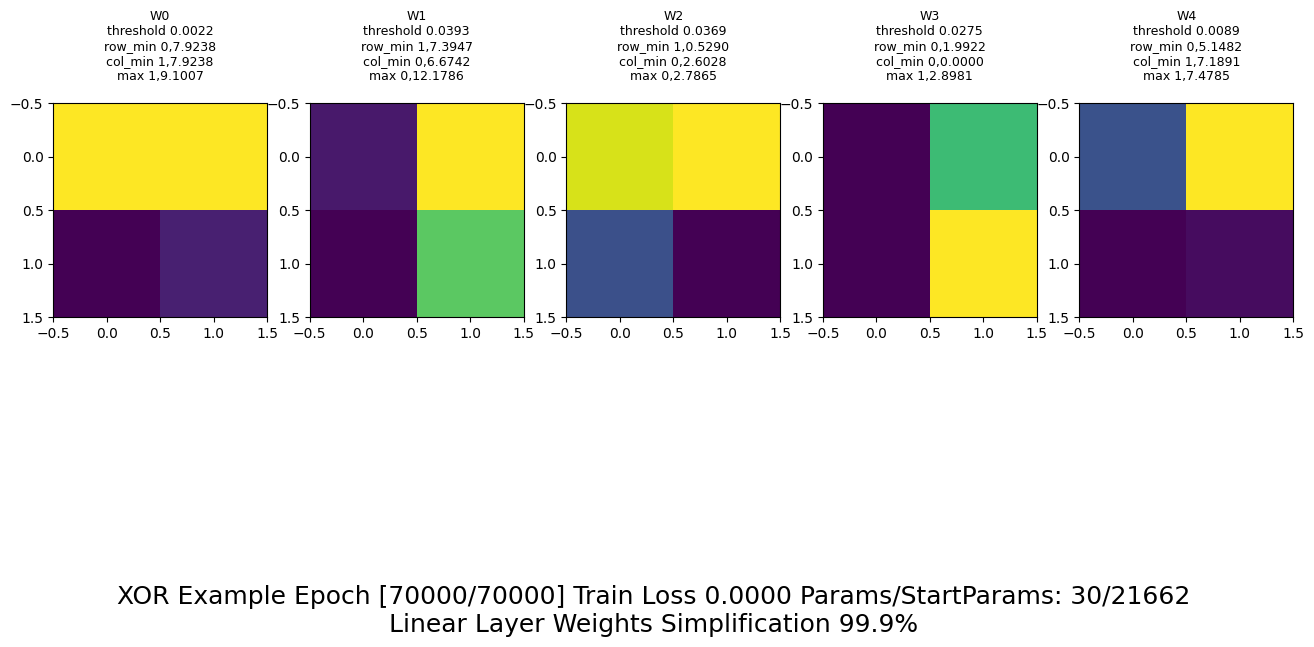

XOR Example Epoch [70000/70000] Train Loss 0.0000 Params/StartParams: 30/21662 Linear Layer Weights Simplification 99.9%


<Figure size 1600x1000 with 0 Axes>

In [4]:
%matplotlib inline

# weights figure
from cv2 import threshold


fig = plt.figure(figsize=(16, 10), facecolor='white')
# select the layers that can be simplified
simplify_layers = [module for module in model.modules() if isinstance(module, SimplifyLinear)]
te = TensorEdit(simplify_layers)
drain_threshold_coeff = 3.0
remove_threshold_coeff = 0.95

# train the model
for epoch in range(epochs):
    output = model.forward(x)
    loss = lossFun(output, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    
    # the force pulling down the weights in the range [-r_value; r_value] to zero
    te.weights_drain(p_drain=0.5, threshold_coeff=drain_threshold_coeff)
    # the following decay avoids getting stuck in the simplification process.
    te.weights_decay(p_decay=0.5, decay_rate=5e-3)
    # remove weights if all values ​​in a row or column are less than the specified value
    if te.weights_remove(p_remove=0.5, threshold_coeff=remove_threshold_coeff, max_removal=1, verbose=True):
        # re-instantiate the optimizer with the new model if I have deleted any rows or columns
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)


    if (epoch+1)%plot_every==0 or epoch+1==epochs:
        if plot_every<500:
            plot_every = int(epoch*0.05)+10
        # calc the simplification as (1-act_params/start_params)%
        n_params = sum(p.numel() for p in model.parameters())
        simplification = (1 - n_params / n_start_params) * 100

        # select the weight matrices transposing them for a better visualization
        weights = [w.weight.data.T for w in simplify_layers]
        title1 = "XOR Example Epoch [{}/{}] Train Loss {:.4f} Params/StartParams: {}/{}"\
                    .format(epoch+1, epochs, loss.item(), n_params, n_start_params)
        title2 = "Linear Layer Weights Simplification {:.1f}%".format(simplification)
        ax_title = []
        for i_w, w in enumerate(weights):
            v_min_row, i_min_row = te.get_min_weight_row_threshold(w)
            v_min_col, i_min_col = te.get_min_weight_col_threshold(w)
            v_max_row, i_max_row = te.get_max_weight_row_threshold(w)
            layer_remove_threshold = remove_threshold_coeff*simplify_layers[i_w].threshold
            ax_title.append("W{}\nthreshold {:.4f}\nrow_min {},{:.4f}\ncol_min {},{:.4f}\nmax {},{:.4f}\n".format(i_w, layer_remove_threshold, i_min_row, v_min_row, i_min_col, v_min_col, i_max_row, v_max_row))
        utils.plot_weights(fig, weights, '\n'.join((title1, title2)), ax_title=ax_title)
        print(' '.join((title1, title2)))

        # create a file name, append it to the filenames list
        filename = '/'.join((outdir, f'frame_{epoch+1}.png'))
        filenames.append(filename)
        # and save the figure
        fig.savefig(filename, facecolor=fig.get_facecolor())
        plt.clf()

In [5]:
# build a gif by composing the frames
utils.images_to_gif(filenames, '/'.join((outdir, 'xor.gif')), tail=100)

# create a mjpg video
utils.images_to_avi(filenames, '/'.join((outdir, 'xor.avi')))

# Remove frame files
for filename in set(filenames):
    os.remove(filename)